In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# Module scripts
from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis, rotate_point
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh
from toss import setup_parameters
from toss import plot_UDP, fitness_over_generations, fitness_over_time, distance_deviation_over_time

# Core packages
from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [127]:
args = setup_parameters()
x = np.genfromtxt('4S_4M_1000Gen_champion_x.csv', delimiter=',')

args.problem.number_of_spacecrafts = 4
args.problem.number_of_maneuvers = 4

# Separate each chromosome representing an induvidual spacecraft:
list_of_spacecrafts = np.array_split(x, args.problem.number_of_spacecrafts)

# Resample and store trajectory for each spacecraft with a fixed time-step delta t
positions = None
velocities = None
timesteps = None
maneuver_times = None
maneuver_vectors = None

for counter, spacecraft in enumerate(list_of_spacecrafts):

    # Compute trajectory
    collision_detected, list_of_ode_objects, _ = compute_trajectory(spacecraft, args, compute_motion)
    
    # Resample trajectory for a fixed time-step delta t
    spacecraft_positions, spacecraft_velocities, spacecraft_timesteps = get_trajectory_fixed_step(args, list_of_ode_objects)

    # Manage maneuvers
    maneuvers = np.array_split(spacecraft[6:],args.problem.number_of_maneuvers) 
    maneuver_t = np.zeros((len(maneuvers)))
    maneuver_v = np.zeros((3,len(maneuvers)))
    maneuver_p = np.zeros((3,len(maneuvers)))
    maneuver_unit_v = np.zeros((3,len(maneuvers)))
    for idx, maneuver in enumerate(maneuvers):
        # store time of maneuver and corresponding control vector
        maneuver_t[idx] = maneuver[0]
        maneuver_v[:,idx] = maneuver[1:]

        # Find position where maneuver was engaged as well as the maneuver unit vector
        maneuver_time_idx = (np.abs(np.asarray(spacecraft_timesteps) - maneuver[0])).argmin()
        maneuver_p[:,idx] = spacecraft_positions[:,maneuver_time_idx]
        maneuver_unit_v[:,idx] = maneuver[1:] / np.linalg.norm(maneuver[1:])


    # Store information
    if counter == 0:
        positions = spacecraft_positions
        velocities = spacecraft_velocities
        timesteps = spacecraft_timesteps
        maneuver_times = maneuver_t
        maneuver_vectors = maneuver_v
        maneuver_positions = maneuver_p
        maneuver_unit_vectors = maneuver_unit_v

    else:
        positions = np.hstack((positions, spacecraft_positions))
        velocities = np.hstack((velocities, spacecraft_velocities))
        maneuver_times = np.hstack((maneuver_times, maneuver_t))
        maneuver_vectors = np.hstack((maneuver_vectors, maneuver_v))
        maneuver_positions = np.hstack((maneuver_positions, maneuver_p))
        maneuver_unit_vectors = np.hstack((maneuver_unit_vectors, maneuver_unit_v))

In [84]:
# Compute fitness
fitness = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("fitness: ", fitness)

fitness:  0.23615686274509806


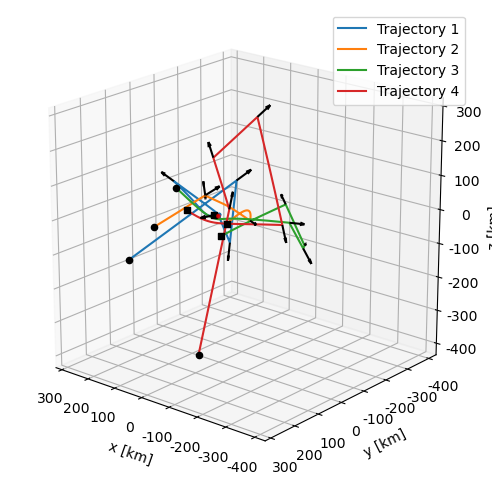

In [151]:
# Plot trajetory
plot_UDP(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, [20,130], None)

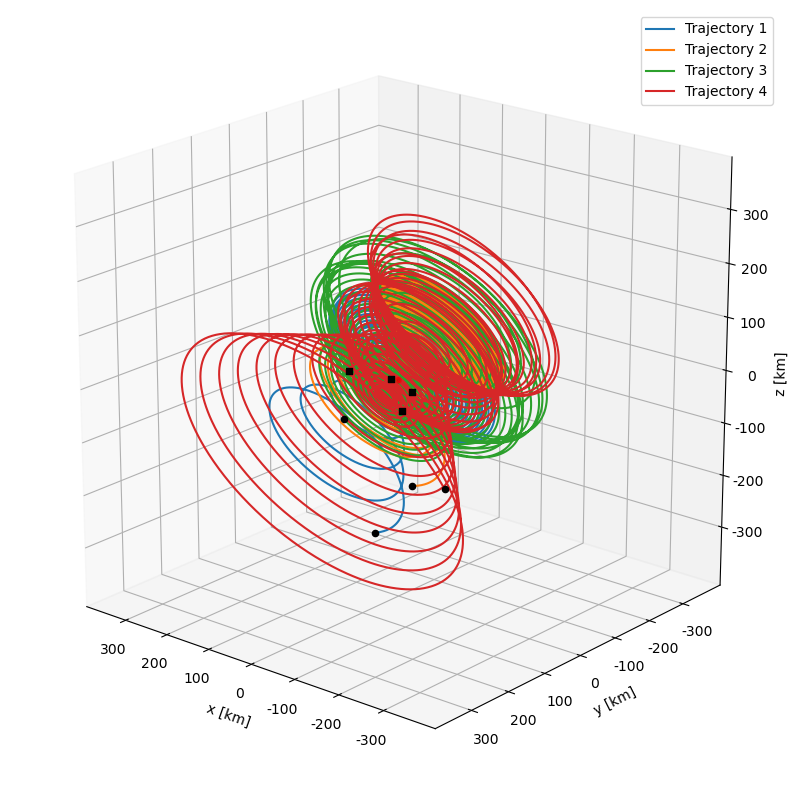

In [113]:
# Fixed body frame trajectory

# Single spacecraft
if args.problem.number_of_spacecrafts == 1:
    rotated_positions = np.zeros(positions.shape)
    for col in range(0,len(positions[0,:])):
        rotated_positions[:,col] = rotate_point(timesteps[col], positions[:,col], args)

# Multiple spacecraft
else:
    pos = np.array_split(positions, args.problem.number_of_spacecrafts, axis=1)
    for i, spacecraft_pos in enumerate(pos):
        pos_rot = np.zeros(spacecraft_pos.shape)
        for col in range(0,len(spacecraft_pos[0,:])):
            pos_rot[:,col] = rotate_point(timesteps[col], spacecraft_pos[:,col], args)
        if i == 0:
            rotated_positions = pos_rot
        else:
            rotated_positions = np.hstack((rotated_positions, pos_rot))


# Plot trajectory
plot_UDP(args, rotated_positions, True, True, True, False, [20,130], None)

728


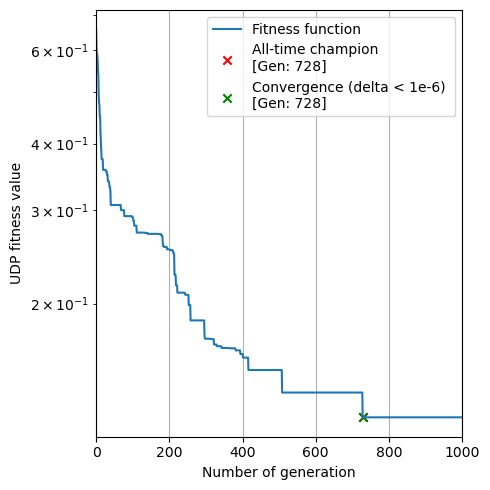

In [104]:
# Plot fitness over generations
fitness_list = np.genfromtxt('4S_4M_1000Gen_fitness_list.csv', delimiter=',')
n_generations = 1000
fitness_over_generations(fitness_list, n_generations)
# fitness_over_generations(np.flip(-1*fitness_list), n_generations) #if fitness has negative values

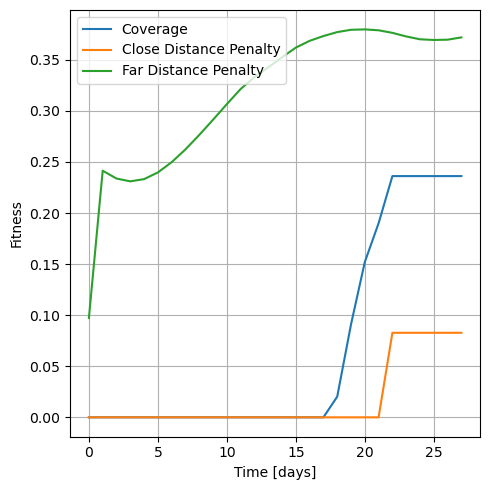

In [106]:
# Plot quality of signal over time

#positions = np.array_split(positions, args.problem.number_of_spacecrafts)
sample_period = int(3600*24/args.problem.measurement_period) #1 day of values in one batch
coverage_list = [0] #zero coverage before mission.

# Compute penalty on initial position:
close_dist_penalty_list = []
far_dist_penalty_list = []
close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))
far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))

# Compute coverage and penatlies evolution over time

# Multiple spacecraft
if args.problem.number_of_spacecrafts > 1:
    positions_list = np.array_split(positions, args.problem.number_of_spacecrafts, axis=1)
    velocities_list = np.array_split(velocities, args.problem.number_of_spacecrafts, axis=1)


    for i in range(sample_period,len(positions_list[0][0,:]), sample_period):
        tstep = timesteps[:i]
        for spacecraft_idx in range(0, len(positions_list)):
            if spacecraft_idx == 0:
                pos = positions_list[spacecraft_idx][:, :i]
                vel = velocities_list[spacecraft_idx][:, :i]
            else:
                pos = np.hstack((pos,positions_list[spacecraft_idx][:, :i]))
                vel = np.hstack((vel,velocities_list[spacecraft_idx][:, :i]))
        
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, tstep))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))


# Single spacecraft
else:
    for i in range(sample_period,len(positions[0,:]), sample_period):
        pos = positions[:, :i]
        vel = velocities[:, :i]
        tstep = timesteps[:i]
        
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, timesteps))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))

# Generate new time axis
time_axis = np.arange(0, int((args.problem.final_time/3600)/24), 1) #+1 to also include day zero with zero coverage.

# plot fitness over time
fitness_over_time(coverage_list, close_dist_penalty_list, far_dist_penalty_list, time_axis)


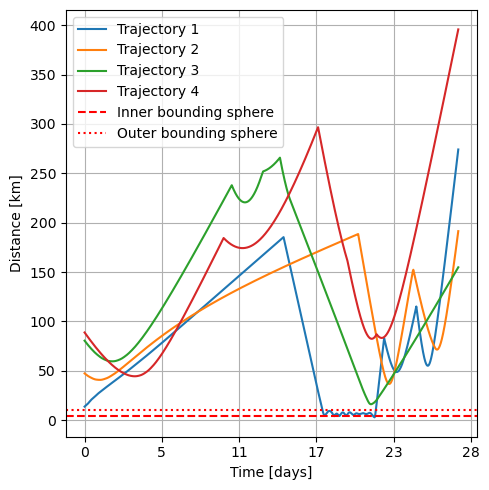

In [107]:
# Distance deviation over time
distance_deviation_over_time(args.problem.number_of_spacecrafts, args.problem.radius_inner_bounding_sphere, args.problem.radius_outer_bounding_sphere, positions, timesteps)